# 4.1. Modelo: Clasificador BERT

Se busca predecir la rama del arbol de categorias(familia, categoria y sub-categoria) en la que se encuentra un producto dado.

### Enlaces

- [The Illustrated BERT, ELMo, and co. (How NLP Cracked Transfer Learning)](http://jalammar.github.io/illustrated-bert/)
- [Text Classification with BERT in PyTorch](https://towardsdatascience.com/text-classification-with-bert-in-pytorch-887965e5820f)
- [Tutorial: Fine tuning BERT for Sentiment Analysis](https://skimai.com/fine-tuning-bert-for-sentiment-analysis/)
- [BERT models](https://huggingface.co/models)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../../src')

from matplotlib import pyplot as plt
import seaborn as sns

import numpy  as np
import pandas as pd

import torch
import transformers
from   torch import nn
from   torch.optim import Adam
    
import logging

from data.fashion import load_datasets
import data  as dt
import model as ml

import util  as ut
import pytorch_common.util as pu

## Setup

Se configura el default logger para que la consola sea el output y loguee mensajes a partir del nivel INFO.

In [3]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

Por defecto usamos GPU. De no existir este hardware, el fallback es CPU:

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.__version__

'1.12.1+cu116'

In [6]:
pu.set_device_name('gpu')

logging.info(pu.get_device())

2022-11-14 13:56:31,420 - INFO - cuda:0


In [7]:
torch.cuda.get_arch_list()

['sm_37', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'sm_80', 'sm_86']

## Funciones Helper

In [8]:
label_by_class = lambda df: {row['branch_seq']: row['branch'] for _, row in df[['branch_seq', 'branch']].drop_duplicates().iterrows() }

## Parametros

Fijamos la semilla para todas las librerias:

In [9]:
ut.set_seed(42)

Definimos el modelo preentrenado a utilizar. Este es una capa/module mas de nuestro modelo.

In [10]:
MODEL_NAME ='bert-base-cased'
# MODEL_NAME ='bert-base-uncased'
# MODEL_NAME = 'bert-large-uncased'
# MODEL_NAME ='distilbert-base-uncased'

Definimos los paths del dataset y pesos del modelo:

In [11]:
DATASET_PATH       = '../../datasets/fashion-outfits'
IMAGES_PATH        = '../../datasets/fashion-outfits/images'
WEIGHTS_PATH       = '../../weights'
CACHE_PATH         = '../../cache'
MODEL_WEIGHTS_PATH = f'{WEIGHTS_PATH}/{MODEL_NAME}.h5'

In [12]:
TRAIN = True

In [13]:
!mkdir -p {WEIGHTS_PATH}

## Cargar dataset

In [14]:
train_set, val_set, test_set = load_datasets(DATASET_PATH, prefix='bert_')

In [15]:
train_set['tokens_count'] = train_set['features'].apply(lambda x: len(x.split(' ')))
val_set['tokens_count']   = val_set['features'].apply(lambda x: len(x.split(' ')))
test_set['tokens_count']  = test_set['features'].apply(lambda x: len(x.split(' ')))

In [16]:
max_tokens_count = max([train_set['tokens_count'].max(), val_set['tokens_count'].max(), test_set['tokens_count'].max()])
max_tokens_count

35

Tamaño máximo de la secuencia de entrada:

In [17]:
tokens_count = 2 + max_tokens_count
tokens_count

37

Definimos el tokenizer y los dataset para tran, validation y test:

In [18]:
tokenizer = ml.Tokenizer(
    tokenizer  = transformers.BertTokenizer.from_pretrained(MODEL_NAME), 
    padding    = 'max_length',
    max_length = tokens_count
)

In [19]:
train_dataset = dt.Dataset(train_set, feature_col = 'features', target_col = 'branch_seq', tokenizer = tokenizer)
val_dataset   = dt.Dataset(val_set,   feature_col = 'features', target_col = 'branch_seq', tokenizer = tokenizer)
test_dataset  = dt.Dataset(test_set,  feature_col = 'features', target_col = 'branch_seq', tokenizer = tokenizer)

## Preparando el modelo

Cantidad de clases a predecir:

In [20]:
len(train_set['branch_seq'].unique())

190

In [21]:
n_classes = train_set['branch_seq'].max() + 1
n_classes

190

In [22]:
classifier = ml.Classifier(
    transformer     = transformers.BertModel.from_pretrained(
        MODEL_NAME, 
        use_cache = True, 
        cache_dir = CACHE_PATH
    ),
    output_dim      = n_classes,
    dropout         = 0,
    hiden_state_dim = 768
)

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

## Entrenamiento

In [23]:
if TRAIN:
    model = ml.ModelTrainer(classifier, batch_size = 40, criterion = nn.CrossEntropyLoss())

In [24]:
if TRAIN:
    LR     = 0.00001
    EPOCHS = 8

    model.fit(
        train_dataset, 
        val_dataset = val_dataset,
        optimizer   = Adam(classifier.parameters(), lr = LR),
        epochs      = EPOCHS
    )

2022-11-14 14:03:02,970 - INFO - Time: 0:03:46.79 | Epoch: 1 | Train(loss: 0.059416, acc: 56.14%) | Val(loss: 0.031440, acc: 72.65%) | acc diff: 16.50%
2022-11-14 14:06:46,789 - INFO - Time: 0:03:43.82 | Epoch: 2 | Train(loss: 0.027141, acc: 74.31%) | Val(loss: 0.024433, acc: 76.15%) | acc diff: 1.84%
2022-11-14 14:10:37,682 - INFO - Time: 0:03:50.89 | Epoch: 3 | Train(loss: 0.022201, acc: 77.33%) | Val(loss: 0.022167, acc: 77.16%) | acc diff: 0.18%
2022-11-14 14:14:23,294 - INFO - Time: 0:03:45.61 | Epoch: 4 | Train(loss: 0.019747, acc: 78.95%) | Val(loss: 0.020577, acc: 78.40%) | acc diff: 0.54%
2022-11-14 14:18:06,388 - INFO - Time: 0:03:43.09 | Epoch: 5 | Train(loss: 0.018077, acc: 80.18%) | Val(loss: 0.020345, acc: 78.56%) | acc diff: 1.62%
2022-11-14 14:21:49,287 - INFO - Time: 0:03:42.90 | Epoch: 6 | Train(loss: 0.016704, acc: 81.34%) | Val(loss: 0.020131, acc: 78.71%) | acc diff: 2.63%
2022-11-14 14:25:32,526 - INFO - Time: 0:03:43.24 | Epoch: 7 | Train(loss: 0.015369, acc: 82.

In [40]:
if TRAIN:
    classifier.save(MODEL_WEIGHTS_PATH)

## Evaluación

In [26]:
classifier.load(MODEL_WEIGHTS_PATH)

In [41]:
model   = ml.ModelTrainer(classifier, batch_size = 40, criterion = nn.CrossEntropyLoss())
summary = model.validate(test_dataset)
summary.show()

Accuracy: 81.00%, Loss: 0.017389


Guardamos target y predicciones:

In [42]:
label_by_class_dict = label_by_class(test_set)

pd.DataFrame({
    'prediction': [label_by_class_dict[e] for e in np.concatenate(summary.predictions)],
    'target'     : [label_by_class_dict[e] for e in np.concatenate(summary.targets)]
}).to_csv(f'{DATASET_PATH}/bert-pred-target.csv', index=False)

In [43]:
np.array(summary.targets).shape

(2848,)

                                                               precision    recall  f1-score   support

                                        accessories~belts~n/d       0.95      0.97      0.96       146
                             accessories~hair accessories~n/d       0.95      0.92      0.94        39
                                         accessories~hats~n/d       0.97      0.99      0.98       254
                    accessories~phone, computer & gadgets~n/d       0.59      0.85      0.69        39
                                      accessories~scarves~n/d       0.99      0.98      0.99      2000
                                   accessories~sunglasses~n/d       1.00      0.98      0.99       186
                              accessories~ties & bow ties~n/d       0.86      0.95      0.90        20
                        accessories~wallets & cardholders~n/d       0.71      0.69      0.70        32
                             accessories~wallets & purses~n/d       0.65

<Figure size 4500x4500 with 2 Axes>

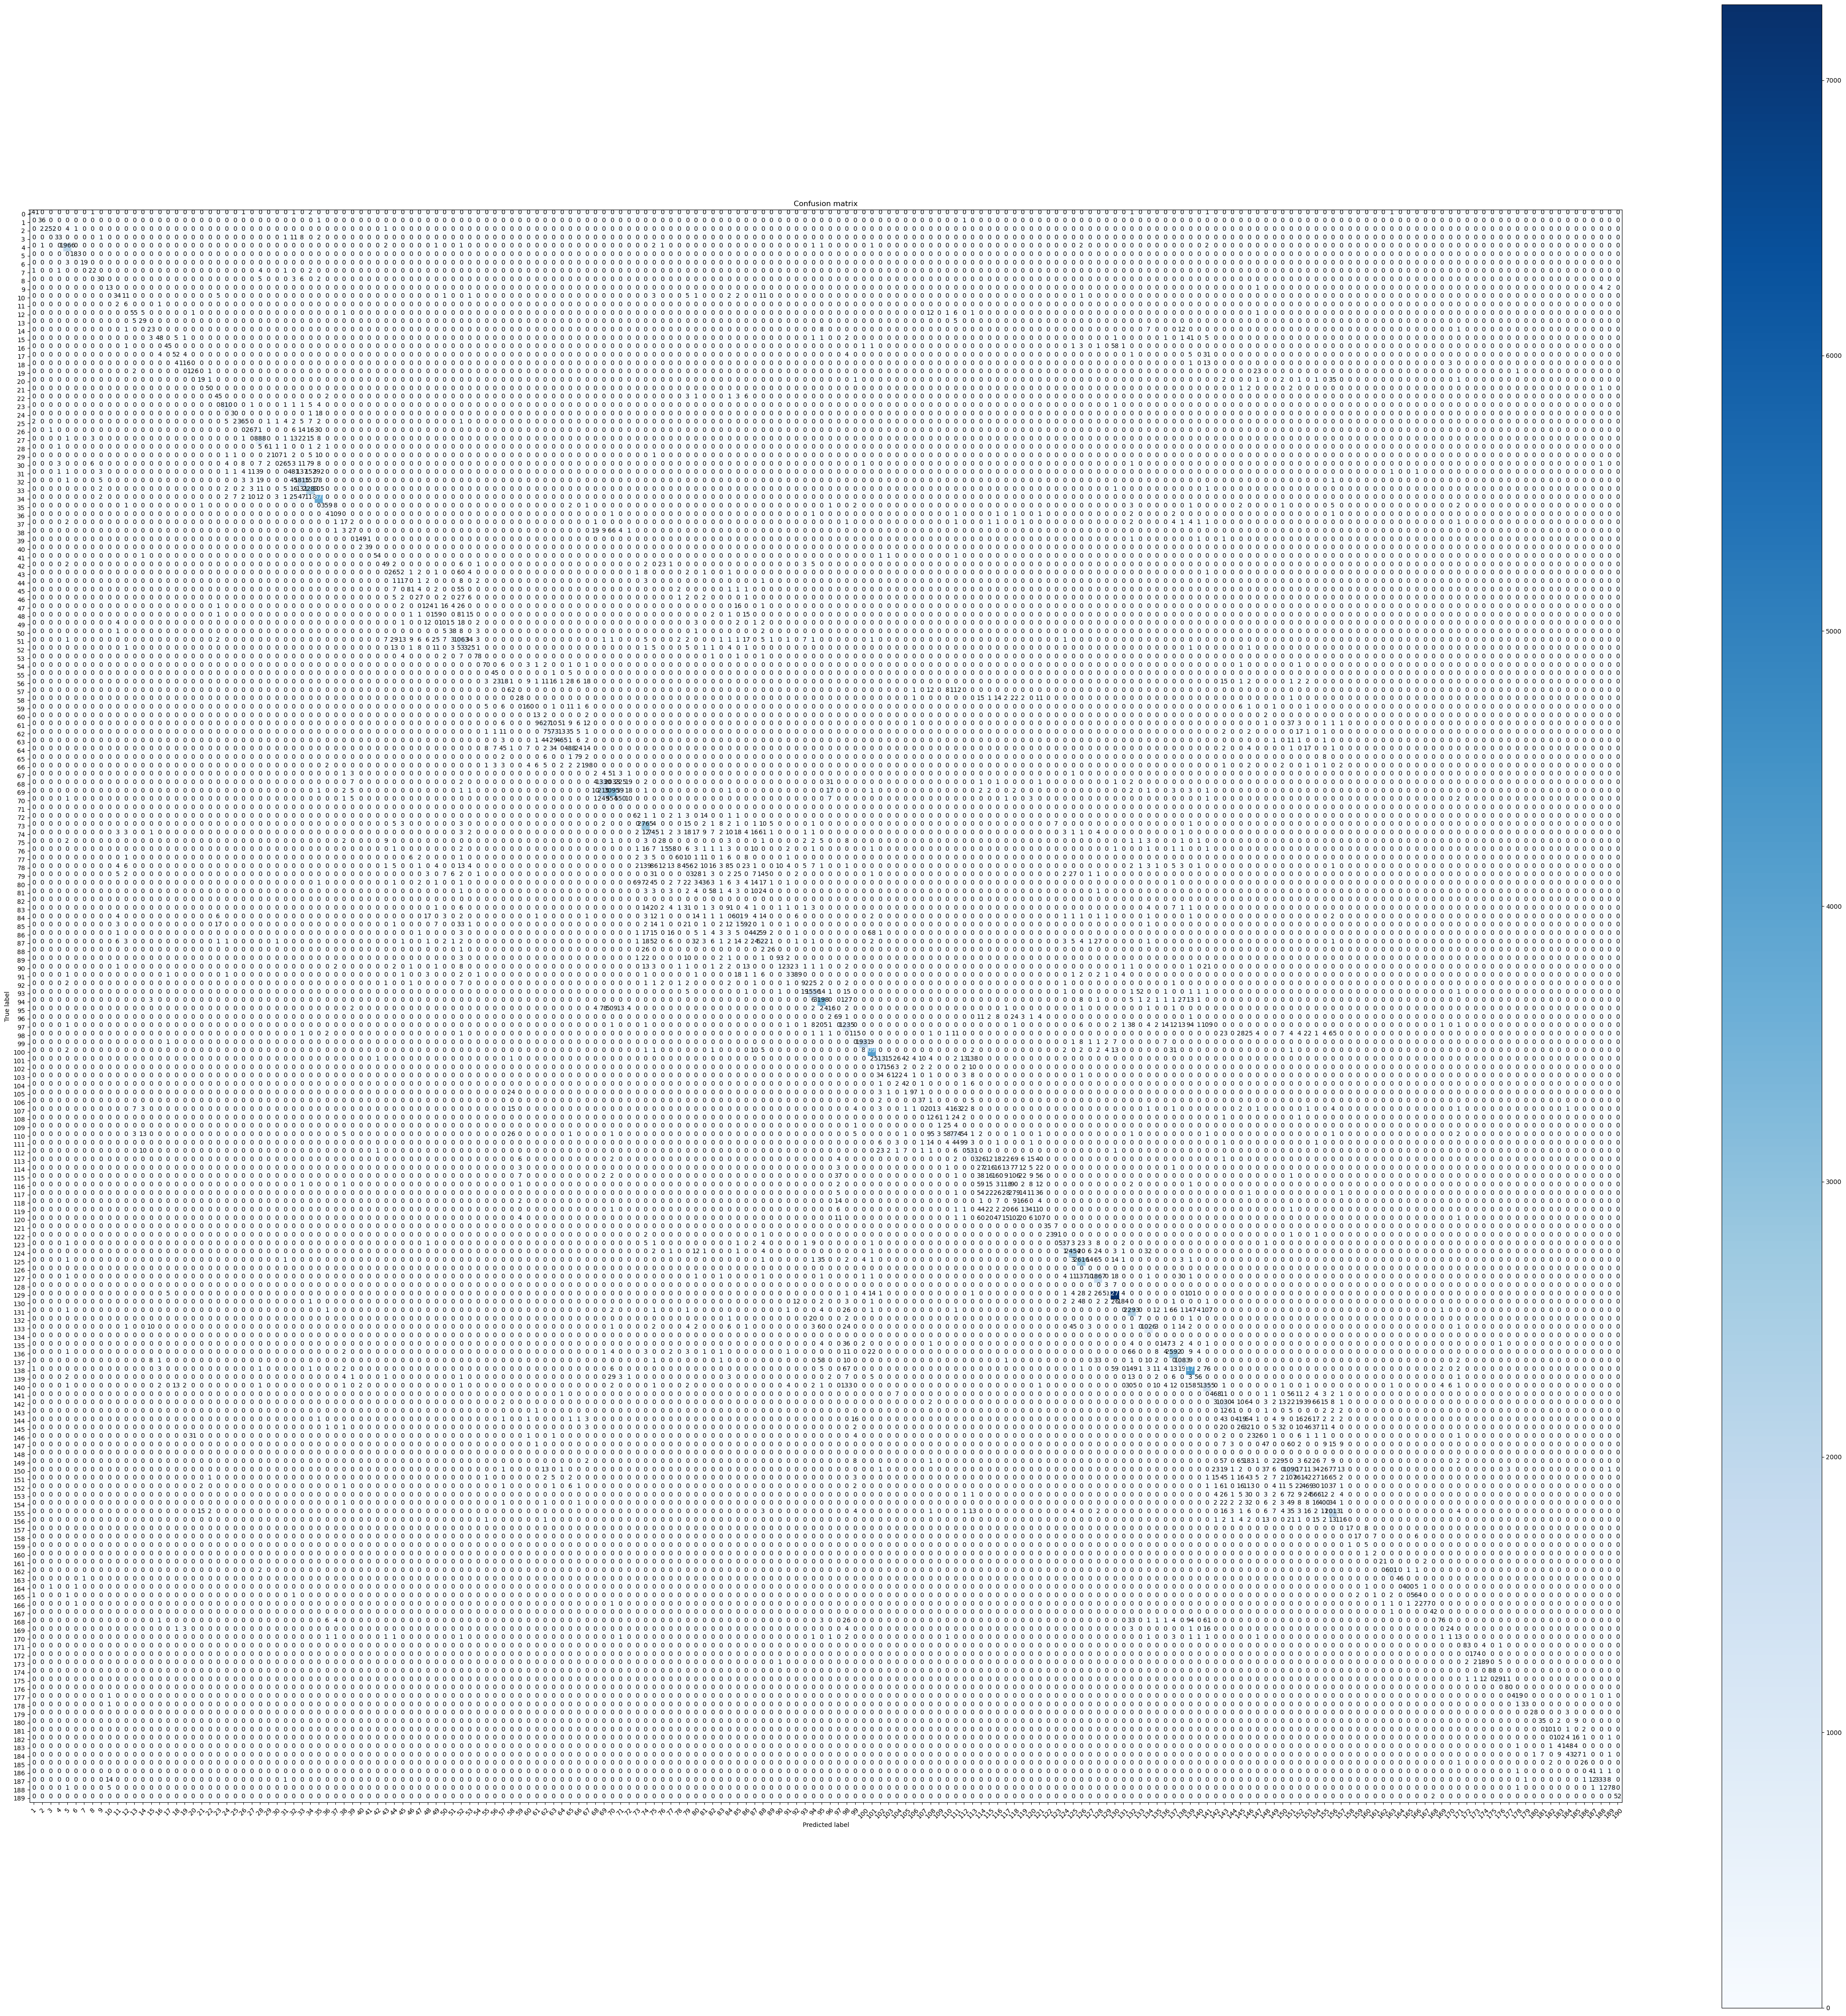

In [44]:
summary.plot_metrics(label_by_class = label_by_class(train_set), figuresize=(45, 45))

In [45]:
report_generator = ml.FailReportGenerator(
    tokenizer, 
    test_set, 
    test_dataset, 
    summary.targets, 
    summary.predictions,
    IMAGES_PATH
)

report = report_generator()

report.to_csv(f'{DATASET_PATH}/bert-model-fail-report.csv', index=False)

Total Fails: 18.68%


Determinamos cuales son las clases con bajo **f1-score**:

In [46]:
less_than_f1_score = 0.5
    
worst_classes = summary.predicted_classes_by(
    less_than_f1_score = less_than_f1_score,
    label_by_class     = label_by_class(train_set)
)
worst_classes

report1 = report[report.true_class.isin(worst_classes)]
report1.to_csv(f'{DATASET_PATH}/f1_score_lt_{less_than_f1_score}-bert-model-fail-report.csv', index=False)
report1.shape, test_set.shape

((3825, 5), (113884, 14))

In [47]:
ut.display_html(report1.sample(frac=1).head(7))

,description,true_class,true_image,pred_class,pred_image
18254,Description : high - waist cotton shorts. Gender : women. Brand : bondi born. Materials : Cotton.,clothing~beachwear~beach cover-ups,,clothing~shorts~short shorts,
19004,Description : lace - patterned sleeveless dress. Gender : women. Brand : ermanno scervino. Materials : Silk Polyamide viscose Cotton,clothing~dresses~cocktail & party dresses,,clothing~dresses~day dresses,
14756,Description : high - waisted wide - leg trousers. Gender : women. Brand : alex perry. Materials : Triacetate Polyester.,clothing~trousers~high-waisted trousers,,clothing~trousers~palazzo pants,
20980,Description : puff - sleeve asymmetric jacket. Gender : women. Brand : simone rocha. Materials : Virgin Wool Polyester visco,clothing~jackets~oversized jackets,,clothing~jackets~fitted jackets,
17989,Description : high - neck belted cotton jacket. Gender : women. Brand : barena. Materials : viscose Polyamide Cotton.,clothing~jackets~oversized jackets,,clothing~jackets~fitted jackets,
10147,Description : asymmetric tailored skirt. Gender : women. Brand : pushbutton. Materials : Polyester Wool.,clothing~skirts~high-waisted skirts,,clothing~skirts~asymmetric & draped skirts,
6197,Description : layered effect shorts. Gender : women. Brand : y's. Materials : Wool.,clothing~shorts~knee-length shorts,,clothing~shorts~short shorts,


In [48]:
less_than_f1_score = 0.27

worst_classes = summary.predicted_classes_by(
    less_than_f1_score = less_than_f1_score,
    label_by_class     = label_by_class(train_set)
)
worst_classes

report1 = report[report.true_class.isin(worst_classes)]
report1.to_csv(f'{DATASET_PATH}/f1_score_lt_{less_than_f1_score}-bert-model-fail-report.csv', index=False)
report1.shape, test_set.shape

((404, 5), (113884, 14))

In [49]:
ut.display_html(report1.sample(frac=1).head(7))

,description,true_class,true_image,pred_class,pred_image
16725,Description : Africana - print beach dress. Gender : women. Brand : emilio pucci. Materials : Cotton.,clothing~dresses~beach dresses,,clothing~beachwear~beach dresses,
12039,Description : merino button - up cardigan. Gender : women. Brand : onefifteen. Materials : Merino.,clothing~tops~cardigans,,clothing~knitwear~cardigans,
3837,Description : floral - lace midi dress. Gender : women. Brand : dolce & gabbana. Materials : Kangaroo Fur viscose Cotton Pol,clothing~dresses~n/d,,clothing~dresses~cocktail & party dresses,
6680,Description : cotton chino trousers. Gender : men. Brand : incotex. Materials : Cotton Spandex / Elastane.,clothing~trousers~n/d,,clothing~trousers~chinos,
17934,Description : logo - print T - shirt. Gender : men. Brand : calvin klein jeans. Materials : Cotton.,clothing~t-shirts & vests~n/d,,clothing~t-shirts & vests~t-shirts,
4062,Description : single - breasted blazer jacket. Gender : men. Brand : solid homme. Materials : Wool.,clothing~jackets~n/d,,clothing~jackets~blazers,
17848,Description : monogram - knit cardigan. Gender : women. Brand : armani exchange. Materials : viscose Polyamide.,clothing~tops~cardigans,,clothing~knitwear~cardigans,


In [50]:
branch_by_seq = {r['branch_seq']: r['branch'] for _, r in train_set[['branch_seq', 'branch']].drop_duplicates().iterrows()}

branch_predictions = [branch_by_seq[e] for e in np.concatenate(summary.predictions)]
branch_targets     = [branch_by_seq[e] for e in np.concatenate(summary.targets)]

family_predictions = [e.split('~')[0] for e in branch_predictions]
family_targets     = [e.split('~')[0] for e in branch_targets]

category_predictions = [e.split('~')[1] for e in branch_predictions]
category_targets     = [e.split('~')[1] for e in branch_targets]

subcategory_predictions = [e.split('~')[2] for e in branch_predictions]
subcategory_targets     = [e.split('~')[2] for e in branch_targets]

                      precision    recall  f1-score   support

         accessories       0.98      0.98      0.98      2759
          activewear       0.67      0.75      0.71       961
                bags       1.00      0.99      1.00     12997
            clothing       1.00      0.99      0.99     91987
 demi-fine jewellery       0.62      0.92      0.74        37
      fine jewellery       0.91      0.62      0.73        47
           jewellery       0.99      0.99      0.99      1959
lingerie & nightwear       0.29      0.72      0.41       160
           pre-owned       1.00      1.00      1.00       938
               shoes       0.99      0.99      0.99      1987
             watches       0.96      1.00      0.98        52

            accuracy                           0.99    113884
           macro avg       0.85      0.90      0.87    113884
        weighted avg       0.99      0.99      0.99    113884



<Figure size 600x600 with 2 Axes>

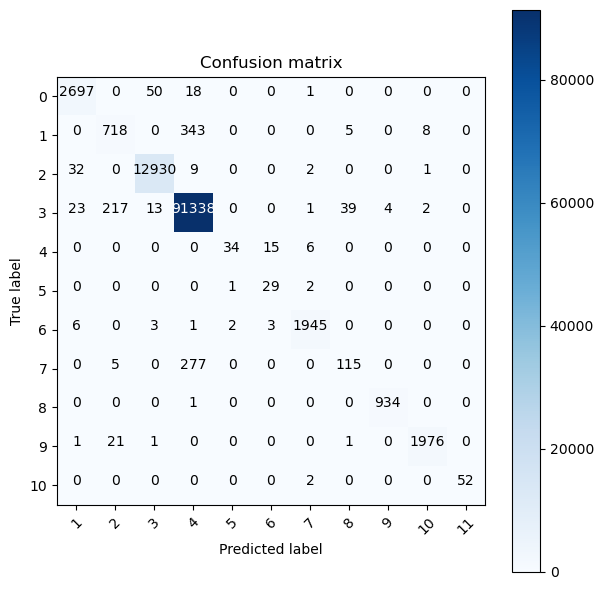

In [51]:
ml.plot_metrics(family_targets, family_predictions, figuresize=(6, 6))

                            precision    recall  f1-score   support

                all in one       0.94      0.95      0.94       505
                 backpacks       0.98      0.98      0.98       827
                beach bags       0.61      0.73      0.67        41
                 beachwear       0.69      0.85      0.76       346
                 belt bags       0.92      0.95      0.93       386
                     belts       0.95      0.97      0.96       146
                    bodies       0.24      0.89      0.38        85
                     boots       0.99      0.99      0.99       424
                 bracelets       0.99      0.99      0.99       608
                      bras       0.46      0.71      0.56        34
           brooches & pins       0.98      1.00      0.99        46
               bucket bags       0.80      0.91      0.85       295
               clutch bags       0.93      0.89      0.91       995
                     coats       0.94      0.93

<Figure size 2000x2000 with 2 Axes>

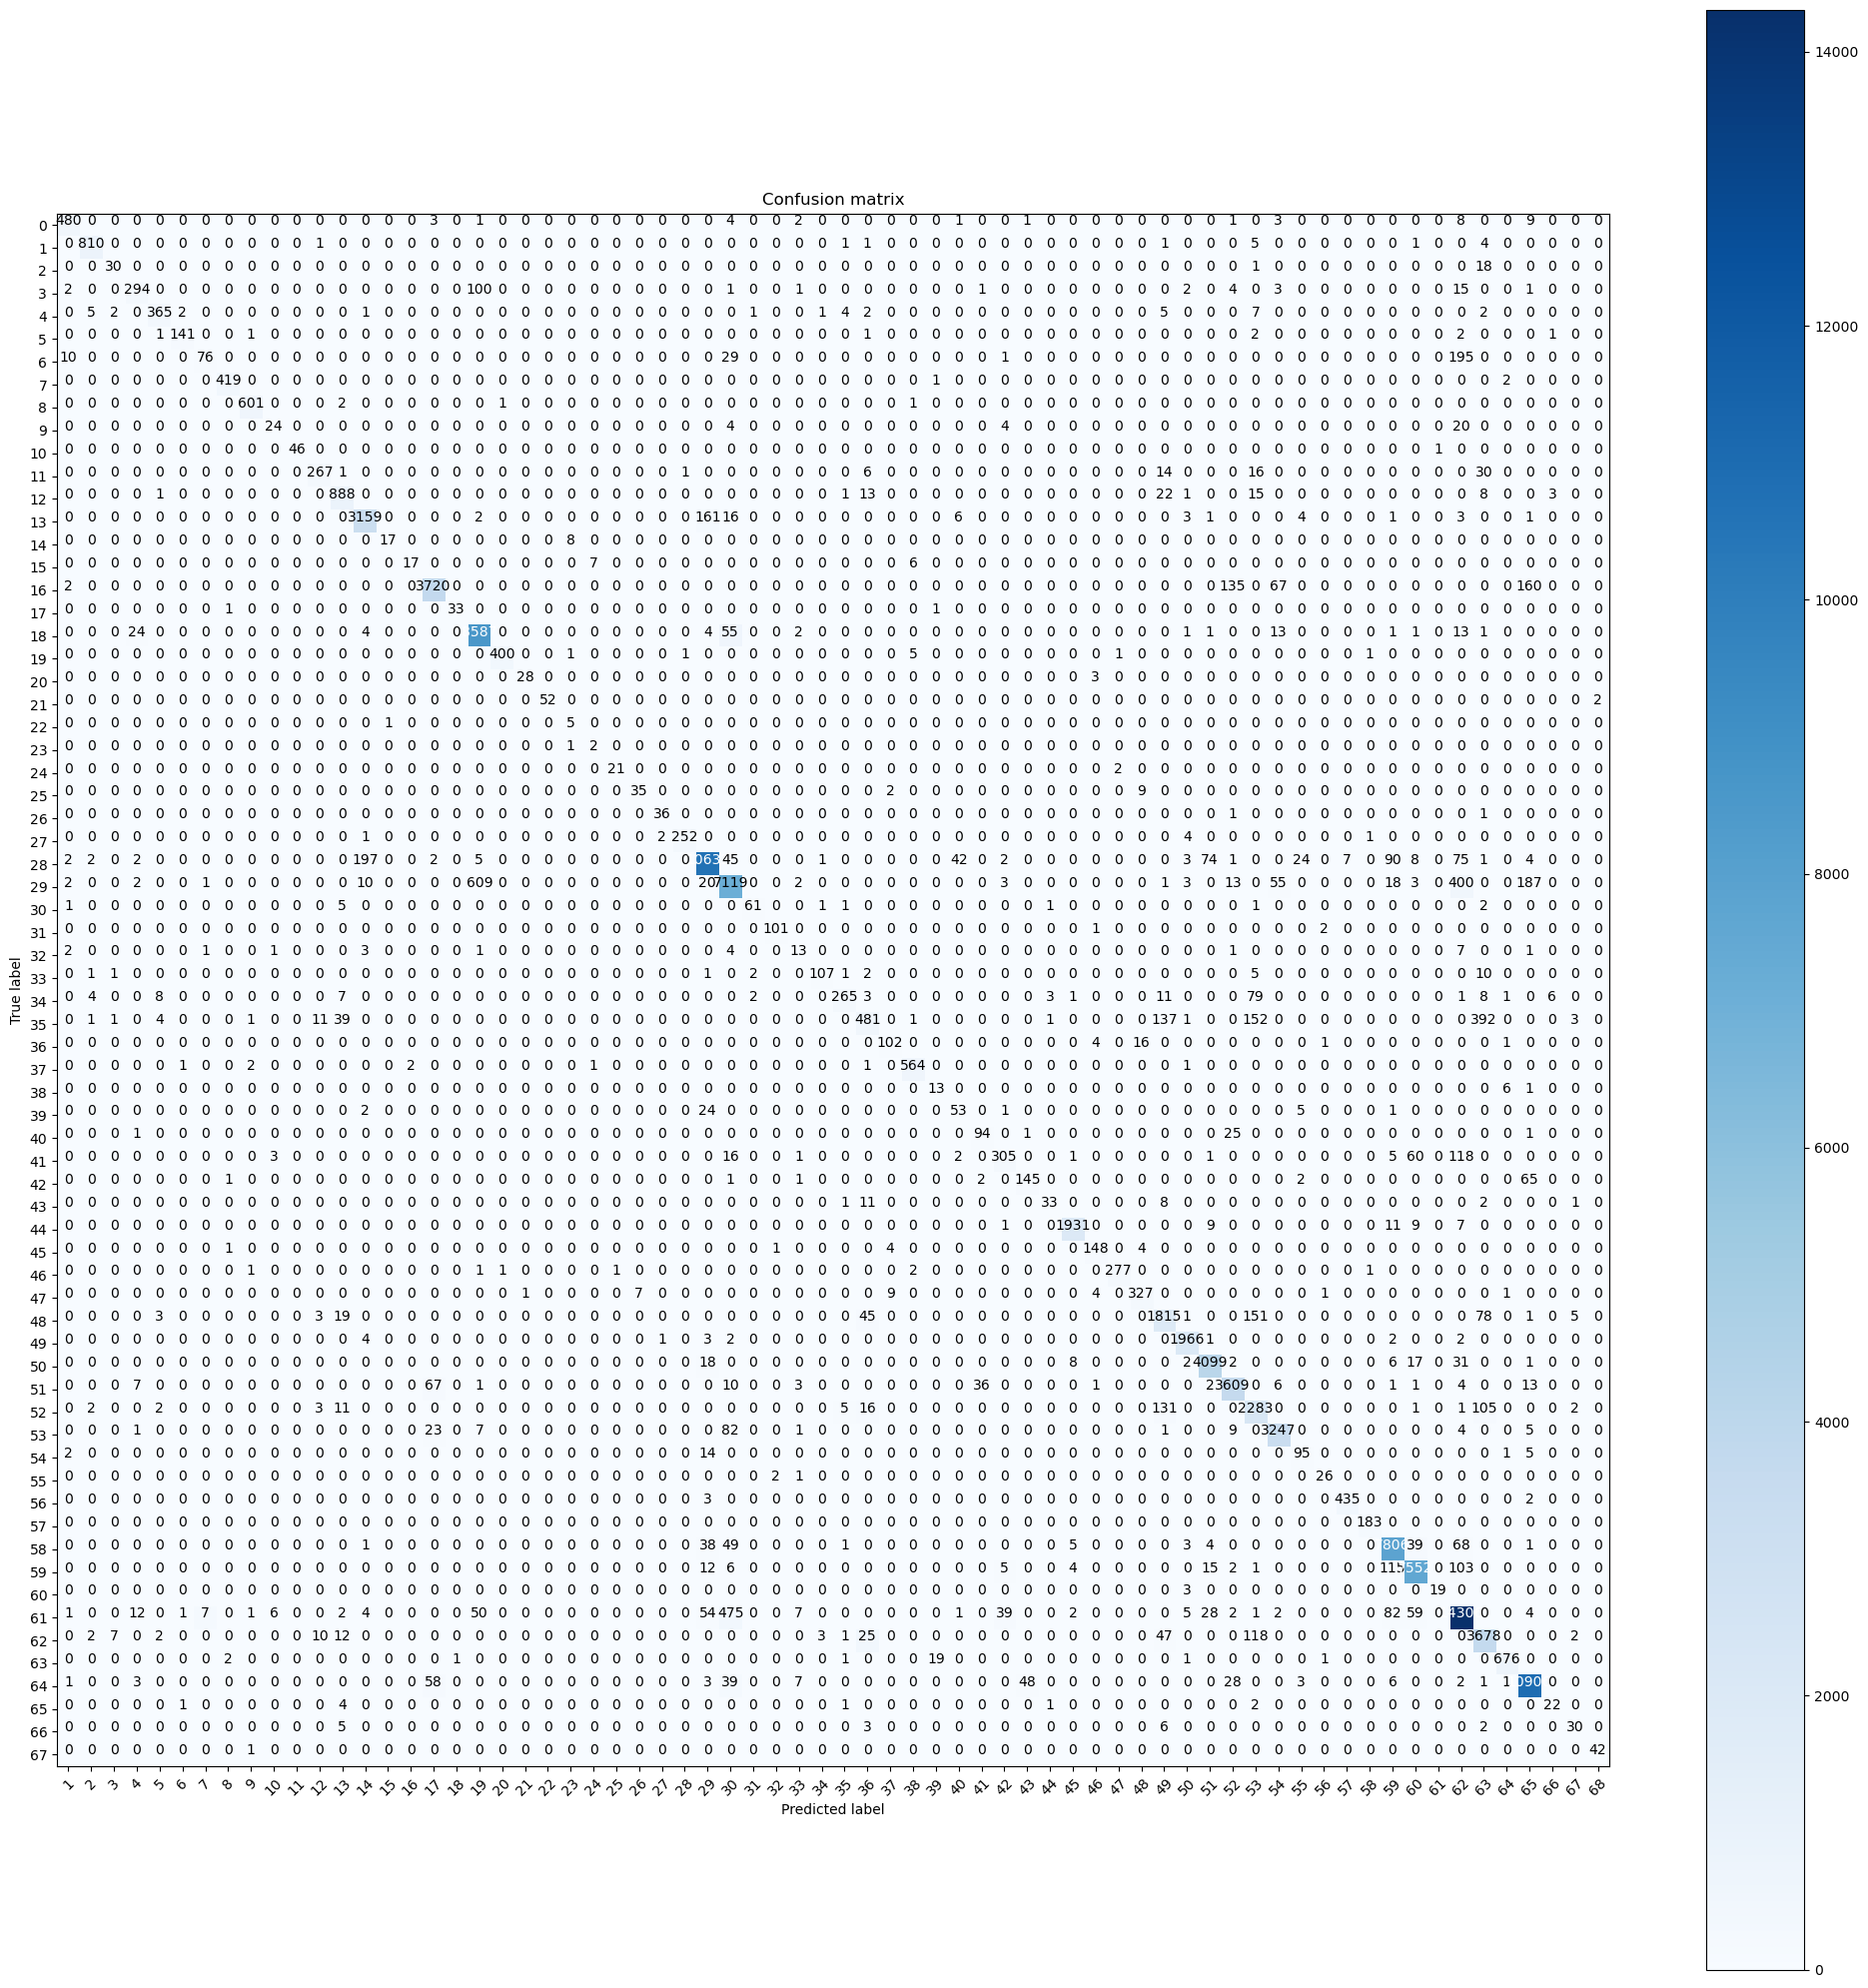

In [52]:
ml.plot_metrics(category_targets, category_predictions, figuresize=(20, 20))

                                   precision    recall  f1-score   support

                    a-line skirts       0.62      0.51      0.56       640
       asymmetric & draped skirts       0.55      0.66      0.60       329
                  beach cover-ups       0.40      0.38      0.39        45
                    beach dresses       0.26      0.55      0.35        93
                   bermuda shorts       0.67      0.85      0.75       606
                    biker jackets       0.72      0.44      0.54       142
                          bikinis       0.97      0.97      0.97       153
                          blazers       0.97      0.87      0.92      3165
                          blouses       0.86      0.78      0.82      2934
                   bomber jackets       0.78      0.70      0.74      1064
                    bootcut jeans       0.81      0.78      0.80        90
                  boyfriend jeans       0.88      0.78      0.83        58
                        

<Figure size 4000x4000 with 2 Axes>

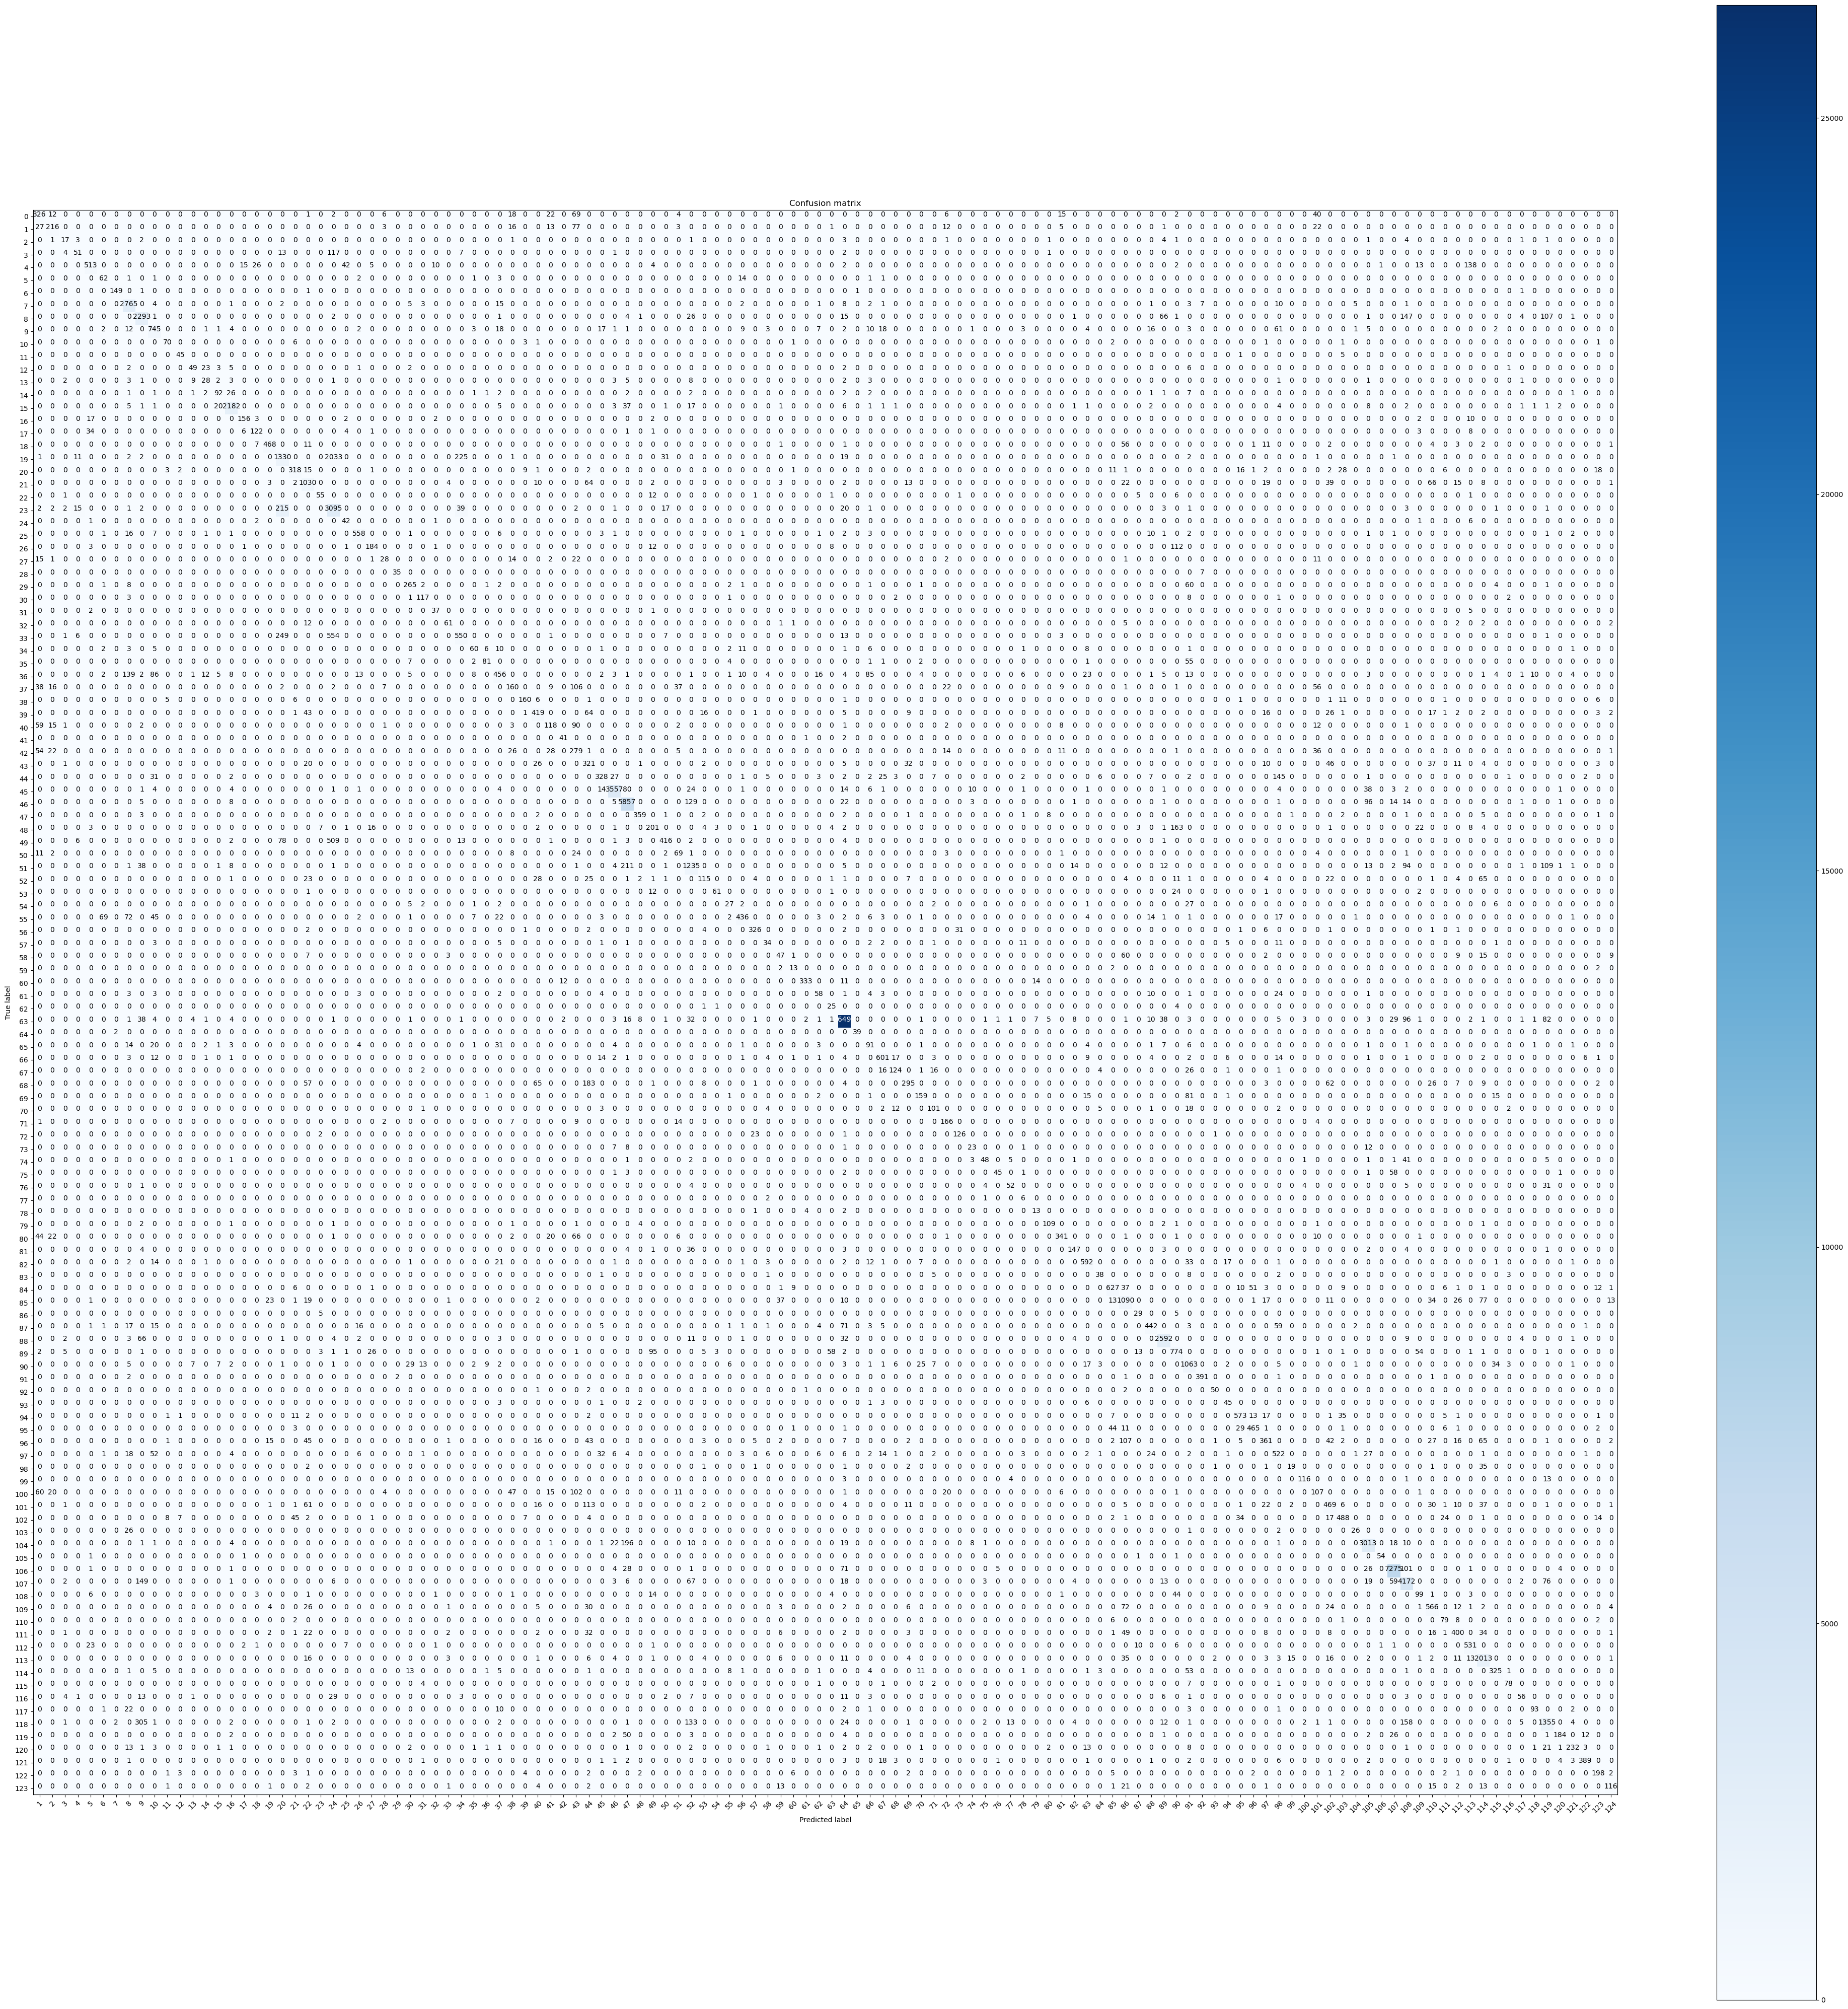

In [53]:
ml.plot_metrics(subcategory_targets, subcategory_predictions, figuresize=(40, 40))